# K-Means Implementation of the Sessa Empirical Estimator (SEE)

In this notebook, we implement the Sessa Empirical Estimator using **K-Means** clustering.


In [1]:
# Cell 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from statsmodels.distributions.empirical_distribution import ECDF

import warnings
warnings.filterwarnings('ignore')


ModuleNotFoundError: No module named 'sklearn'

In [2]:
# Cell 2: Load and Prepare the Data
def load_data(filepath="../data/med_events.csv"):
    """
    Loads the medication events CSV and standardizes column names.
    """
    df = pd.read_csv(filepath)
    # Adjust column names as needed for your CSV
    df.columns = ['PATIENT_ID', 'DATE', 'PERDAY', 'CATEGORY', 'DURATION']
    df['DATE'] = pd.to_datetime(df['DATE'], format='%m/%d/%Y')
    return df

# Load the data
med_events = load_data()
med_events.head()


,PATIENT_ID,DATE,PERDAY,CATEGORY,DURATION
0,1,2033-04-26,4,medA,50
1,1,2033-07-04,4,medB,30
2,1,2033-08-03,4,medB,30
3,1,2033-08-17,4,medB,30
4,1,2033-10-13,4,medB,30


In [4]:
# Cell 3: Define the K-Means-based SEE Function
def see_kmeans(data, medication_code):
    """
    Python implementation of the Sessa Empirical Estimator using K-Means.
    Returns a DataFrame with cluster assignments.
    """
    # 1. Filter for the specified medication
    drug_see_p0 = data[data['CATEGORY'] == medication_code].copy()
    drug_see_p1 = drug_see_p0.copy()
    
    # 2. Sort by patient and date, compute previous prescription date
    drug_see_p1 = drug_see_p1.sort_values(by=['PATIENT_ID', 'DATE'])
    drug_see_p1['prev_date'] = drug_see_p1.groupby('PATIENT_ID')['DATE'].shift(1)
    drug_see_p1.dropna(subset=['prev_date'], inplace=True)
    
    # 3. Randomly select one record per patient
    drug_see_p1 = drug_see_p1.groupby('PATIENT_ID').apply(
        lambda x: x.sample(1, random_state=1234)
    ).reset_index(drop=True)
    
    # 4. Calculate the event interval (days)
    drug_see_p1['event_interval'] = (drug_see_p1['DATE'] - drug_see_p1['prev_date']).dt.days
    
    # 5. Compute ECDF
    intervals = np.sort(drug_see_p1['event_interval'].values)
    ecdf_vals = np.arange(1, len(intervals)+1) / len(intervals)
    df_ecdf = pd.DataFrame({'x': intervals, 'y': ecdf_vals})
    
    # 6. Plot 80% vs. 100% ECDF
    df_ecdf_80 = df_ecdf[df_ecdf['y'] <= 0.8]
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.scatter(df_ecdf_80['x'], df_ecdf_80['y'])
    plt.title('80% ECDF')
    
    plt.subplot(1,2,2)
    plt.scatter(df_ecdf['x'], df_ecdf['y'])
    plt.title('100% ECDF')
    plt.tight_layout()
    plt.show()
    
    # 7. Filter intervals within 80%
    ni = df_ecdf_80['x'].max()
    drug_see_p2 = drug_see_p1[drug_see_p1['event_interval'] <= ni].copy()
    
    # 8. Plot density of log(event_interval)
    log_intervals = np.log(drug_see_p2['event_interval'].astype(float))
    plt.figure(figsize=(8,5))
    sns.kdeplot(log_intervals, shade=True)
    plt.title('Log(event interval)')
    plt.show()
    
    # 9. Determine optimal K via silhouette
    X = np.column_stack((log_intervals, log_intervals))
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    silhouette_scores = []
    K_range = range(2, 10)
    for k in K_range:
        km = KMeans(n_clusters=k, random_state=1234)
        km.fit(X)
        score = silhouette_score(X, km.labels_)
        silhouette_scores.append(score)
    
    plt.figure(figsize=(8,5))
    plt.plot(K_range, silhouette_scores, 'bo-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Analysis')
    plt.show()
    
    optimal_k = K_range[np.argmax(silhouette_scores)]
    print("Optimal K =", optimal_k)
    
    # 10. Perform K-Means clustering on df_ecdf
    km = KMeans(n_clusters=optimal_k, random_state=1234)
    df_ecdf['cluster'] = km.fit_predict(df_ecdf[['x']].values)
    
    # 11. Generate summary stats
    cluster_stats = df_ecdf.groupby('cluster')['x'].agg(['min','max','median']).reset_index()
    cluster_stats.columns = ['Cluster','Minimum','Maximum','Median']
    
    # 12. Merge clusters back
    results = pd.DataFrame()
    for _, row in cluster_stats.iterrows():
        matched = drug_see_p1[
            (drug_see_p1['event_interval'] >= row['Minimum']) & 
            (drug_see_p1['event_interval'] <= row['Maximum'])
        ].copy()
        matched['Cluster'] = row['Cluster']
        matched['Median'] = row['Median']
        results = pd.concat([results, matched])
    
    # 13. Handle unmatched
    if not results.empty:
        freq = results['Cluster'].value_counts().reset_index()
        freq.columns = ['Cluster','Freq']
        most_common = freq.iloc[0]['Cluster']
        default_median = results[results['Cluster'] == most_common]['Median'].iloc[0]
    else:
        default_median = np.nan
    
    drug_see_p1 = pd.merge(drug_see_p1, results[['PATIENT_ID','Median','Cluster']], 
                           on='PATIENT_ID', how='left')
    drug_see_p1['Median'] = drug_see_p1['Median'].fillna(default_median)
    drug_see_p1['Cluster'] = drug_see_p1['Cluster'].fillna(0)
    drug_see_p1['test'] = (drug_see_p1['event_interval'] - drug_see_p1['Median']).round(1)
    
    # 14. Merge final
    final_df = pd.merge(drug_see_p0, drug_see_p1[['PATIENT_ID','Median','Cluster']], 
                        on='PATIENT_ID', how='left')
    final_df['Median'] = final_df['Median'].fillna(default_median)
    final_df['Cluster'] = final_df['Cluster'].fillna(0)
    
    return final_df


In [5]:
# Cell 4: Define Assumption Check Function
def see_assumption(data):
    """
    Check assumptions by plotting durations for each prescription number.
    """
    data_sorted = data.sort_values(by=['PATIENT_ID','DATE']).copy()
    data_sorted['prev_date'] = data_sorted.groupby('PATIENT_ID')['DATE'].shift(1)
    data_sorted['p_number'] = data_sorted.groupby('PATIENT_ID').cumcount() + 1
    df_box = data_sorted[data_sorted['p_number'] >= 2].copy()
    df_box['Duration'] = (df_box['DATE'] - df_box['prev_date']).dt.days
    
    plt.figure(figsize=(10,6))
    sns.boxplot(x='p_number', y='Duration', data=df_box)
    # median of medians
    medians = df_box.groupby('PATIENT_ID')['Duration'].median().median()
    plt.axhline(medians, color='red', linestyle='--', label=f'Median = {medians:.1f}')
    plt.title("Duration by Prescription Number")
    plt.xlabel("Prescription Number")
    plt.ylabel("Duration (days)")
    plt.legend()
    plt.show()


C:\Users\angel\AppData\Local\Temp\ipykernel_8364\3394485507.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  drug_see_p1 = drug_see_p1.groupby('PATIENT_ID').apply(


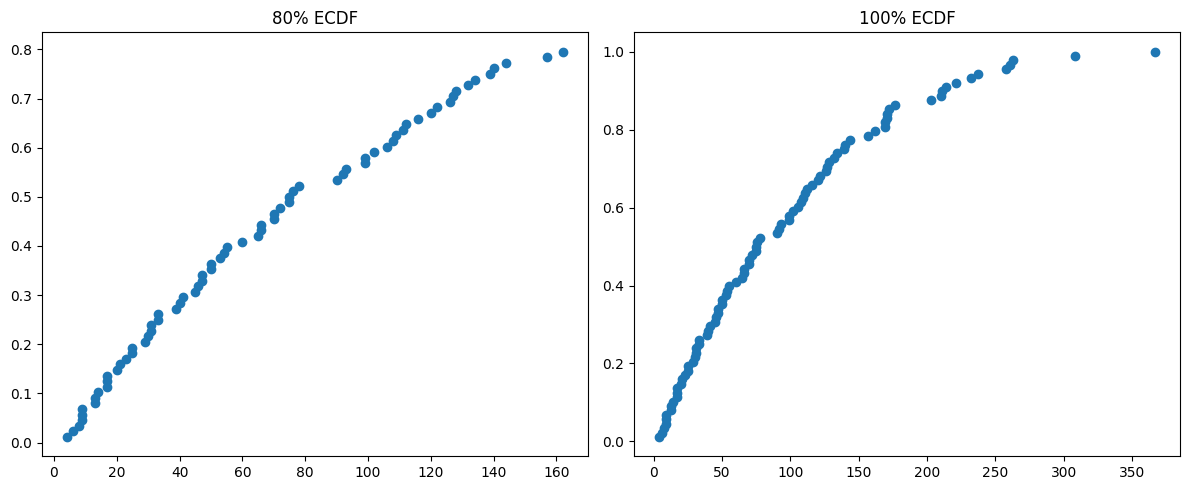

C:\Users\angel\AppData\Local\Temp\ipykernel_8364\3394485507.py:49: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(log_intervals, shade=True)


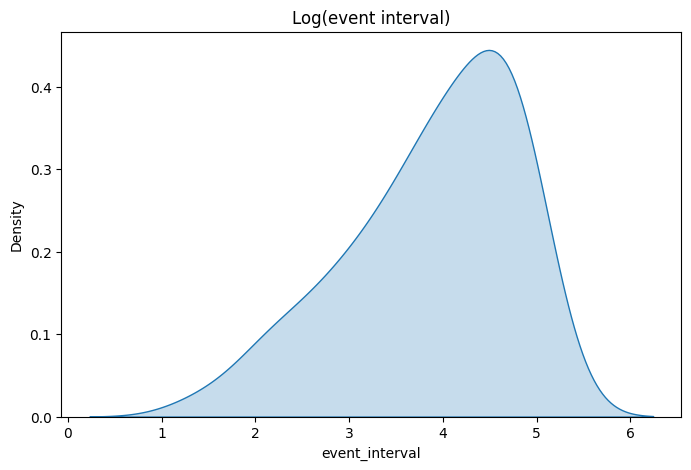

NameError: name 'KMeans' is not defined

In [6]:
# Cell 5: Run the SEE for K-Means & Generate Insights
result_kmeans_medA = see_kmeans(med_events, 'medA')
display(result_kmeans_medA.head())

print("\nChecking assumptions for medA (K-Means):")
see_assumption(result_kmeans_medA)



# Cell 6: Insights

**Observations:**
